In [1]:
# third party libraries
import sys, os
sys.path.append("../..")
sys.path.append("..")
sys.path.append(os.getcwd())
from matplotlib import pyplot as plt
from sklearn.model_selection import ParameterGrid
import numpy as np
import pandas as pd
import pickle

# personal libraries
from mrsc.src.model.SVDmodel import SVDmodel
from mrsc.src.model.Target import Target
from mrsc.src.model.Donor import Donor
from mrsc.src.synthcontrol.mRSC import mRSC
from mrsc.src.dataPrep.importData import *
import mrsc.src.utils as utils

import heapq

# dennis libraries
from mrsc.src.dataPrep import plotData, gameData, annualData
from mrsc.src.predictions import cvxRegression, predictionMethods, SLA, gamePredictions, annualPredictions

/anaconda3/lib/python3.7/site-packages/statsmodels/compat/pandas.py:49: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


In [2]:
def approximate_rank(X, t = 0.99):
    """
    Input:
        X: matrix of interest
        t: an energy threshold. Default (0.99 = 99%)
        
    Output:
        r: approximate rank of Z
    """
    u, s, v = np.linalg.svd(X, full_matrices=False)
    total_energy = (s**2).cumsum()/(s**2).sum()
    r = list((total_energy>t)).index(True)+1
    return r

""" Read in Games Data and create DataFrame """
def createGameData():
    df = pd.read_csv("../data/nba-enhanced-stats/2012-18_playerBoxScore.csv")
    
    game_metrics = ['playPTS', 'playAST', 'playTO','playFG%','playFT%','play3PM','playTRB','playSTL', 'playBLK']
    year_metrics = ['PTS_G','AST_G','TOV_G','TRB_G','STL_G','BLK_G','3P_G','FG%','FT%']
    colname_dict = {'playPTS': 'PTS_G', 'playAST': 'AST_G', 'playTO':'TOV_G',
                    'playFG%': 'FG%','playFT%':'FT%','play3PM':'3P_G',
                    'playTRB':'TRB_G','playSTL':'STL_G','playBLK':'BLK_G'}

    # edit column names to fit with the yearly data
    df = df.rename(columns=colname_dict)

    # add date column
    #date_col = pd.to_datetime(df.gmDate + " " + df.gmTime, format='%Y-%m-%d %H:%M').rename("date")
    date_col = pd.to_datetime(df.gmDate, format='%Y-%m-%d').rename("date")
    df = pd.concat([date_col, df], axis=1)

    # relevant columns
    cols = ['date', 'gmDate', 'playDispNm', 'teamAbbr', 'teamLoc', 'teamRslt', 'teamDayOff', 'playStat', 'playPos', 'playMin', 'opptAbbr', 'opptDayOff']
    df_games = df[cols + year_metrics]
    df_games = df_games.rename(columns={"playDispNm": "Player"})

    # fix special characters
    df_games.Player = df_games.Player.str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')
    
    return df_games

# GAME PREDICTIONS
#### use annual forecast for game predictions in beginning

In [3]:
""" Parameters """
min_mp = 15

In [4]:
# read in data
df_games = gameData.createGameData()
#df_games = df_games[df_games.playMin >= min_mp]

# train/validation/test dates
trainDates = ('2012-09-01', '2016-06-01')
cvDates = ('2016-09-01', '2017-06-01')
testDates = ('2017-09-01', '2018-06-01')

# split data into train/cv/test
dfTrain, dfCV, dfTest = gameData.splitDFs(df_games, trainDates, cvDates, testDates)
dfTrainCV = pd.concat([dfTrain, dfCV])

# team data
teams = df_games.teamAbbr.unique()

# save
#gameData.saveTeamsDict(dfTrain, dfCV, dfTest, dfTrainCV, teams)
#gameData.saveTeamsPosDict(dfTrain, dfCV, dfTest, dfTrainCV, teams)

# load 
teamsPosTrainDict, teamsPosCVDict, teamsPosTestDict, teamsPosTrainCVDict = gameData.loadTeamsPosDict()
teamsTrainDict, teamsCVDict, teamsTestDict, teamsTrainCVDict = gameData.loadTeamsDict()

train...
CV...
Test...
TrainCV...
Done!


In [22]:
# feature parameters
statsWindow = np.array([3])
statsCom = np.array([0.2])
gmWindow = np.array([3])
gmCom = np.array([0.3])
opptWindow = np.array([-1])
teamWindow = np.array([10])
teamCom = np.array([0.2])
n = np.array([1])

# model parameters
rank = np.array([3])
project = [True]
updateType = ['raw'] #, 'project', 'none'
updatePeriod = np.array([20])

# sla parameters
slaType = ['lwr']
alpha = np.array([0.1])
radius = np.array([4])
n_neighbors = np.array([3])
weights = ['distance']
p = np.array([2])
algo = ['auto']
leaf_size = np.array([30])
kernel = ['rbf'] #'sigmoid', 'cosine', 'poly'
fit_intercept = [True]

hyperparamDict = {'statsWindow': statsWindow, 'statsCom': statsCom, 'gmWindow': gmWindow,
            'gmCom': gmCom, 'opptWindow': opptWindow, 'teamWindow': teamWindow, 
            'teamCom': teamCom, 'n': n, 'rank': rank, 'project': project, 
            'updatePeriod': updatePeriod, 'updateType': updateType,
            'type': slaType, 'alpha': alpha, 'radius': radius, 'p': p, 
            'n_neighbors': n_neighbors, 'weights': weights, 'algo': algo, 'leaf_size': leaf_size,
            'kernel': kernel, 'fit_intercept': fit_intercept}
paramGrid = list(ParameterGrid(hyperparamDict))

## Cross Validation 

{'std': {'window': 3}, 'mean': {'window': 3}, 'ewm': {'window': 3, 'com': 0.2}, 'gmOutcome': {'window': 3, 'com': 0.3}, 'delta': {'window': 3, 'com': 0.2}, 'teammates': {'window': 10, 'n': 1, 'com': 0.2}, 'oppt': {'window': -1}, 'teamLoc': {}}
{'rank': 3, 'project': True, 'updateType': 'raw', 'updatePeriod': 20}
{'type': 'lwr', 'params': {'kernel': 'rbf', 'alpha': 0.1, 'fit_intercept': True}}


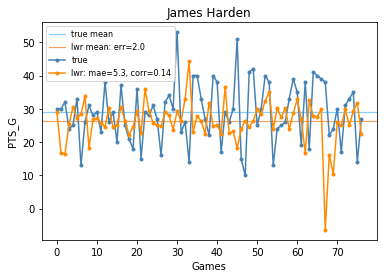

James Harden: {'algo': 'auto', 'alpha': 0.1, 'fit_intercept': True, 'gmCom': 0.3, 'gmWindow': 3, 'kernel': 'rbf', 'leaf_size': 30, 'n': 1, 'n_neighbors': 3, 'opptWindow': -1, 'p': 2, 'project': True, 'radius': 4, 'rank': 3, 'statsCom': 0.2, 'statsWindow': 3, 'teamCom': 0.2, 'teamWindow': 10, 'type': 'lwr', 'updatePeriod': 20, 'updateType': 'raw', 'weights': 'distance'}
Error = 5.34
James Harden: {'algo': 'auto', 'alpha': 0.1, 'fit_intercept': True, 'gmCom': 0.3, 'gmWindow': 3, 'kernel': 'rbf', 'leaf_size': 30, 'n': 1, 'n_neighbors': 3, 'opptWindow': -1, 'p': 2, 'project': True, 'radius': 4, 'rank': 3, 'statsCom': 0.2, 'statsWindow': 3, 'teamCom': 0.2, 'teamWindow': 10, 'type': 'lwr', 'updatePeriod': 20, 'updateType': 'raw', 'weights': 'distance'}
Corr = 0.14



In [23]:
featureTypes = ['std', 'mean', 'ewm', 'gmOutcome', 'delta', 'teammates', 'oppt', 'teamLoc']  #'gmOutcome', 'delta', 'teammates', 'oppt', 'teamLoc'
labelType = 'none'
players = ['James Harden']
metric = 'PTS_G'

folderName = 'SLA/'
saveFig = False
errorType = 'mae'
players_optParamDict_error = {player: {} for player in players}
players_optParamDict_corr = {player: {} for player in players}
alpha = 1

for player in players:
    # create info and SLA dictionaries
    infoDict = {'player': player, 'metric': metric} 
    
    # initialize optimality conditions
    optParamDict_error = paramGrid[0]
    optParamDict_corr = paramGrid[0]
    error = float('inf')
    corr = -float('inf')
    
    # iterate through parameters
    for paramDict in paramGrid:
        # create parameter dictionaries
        infoDict, featuresDict, labelsDict, modelDict, slaDict = gamePredictions.getParamDicts(paramDict, infoDict, 
                                                                               featureTypes, labelType)
        #if 'delta' in list(featuresDict.keys()): 
            #infoDict['buffer'] += 1
            
        print(featuresDict)
        print(modelDict)
        print(slaDict)
        
        # train 
        dataDict = {'df': dfTrain, 'teamsDict': teamsTrainDict}
        SLA.trainSLA(infoDict, dataDict, featuresDict, labelsDict, modelDict, slaDict)
        
        # test 
        dataDict = {'df': dfCV, 'teamsDict': teamsCVDict}
        preds, true = SLA.testSLA(infoDict, dataDict, featuresDict, labelsDict, modelDict, slaDict)
        
        # restrict to games that we care about
        true_alpha, preds_alpha = gamePredictions.get_alpha_scores(true, preds, alpha)
        
        # compute correlation for restricted games
        corrTemp = gamePredictions.corr(preds_alpha, true_alpha)
        if corrTemp > corr: 
            corr = corrTemp
            optParamDict_corr = paramDict
            
        # compute error for restricted games
        errorTemp = gamePredictions.error(preds_alpha, true_alpha, errorType=errorType)
        if errorTemp < error: 
            error = errorTemp
            optParamDict_error = paramDict
            
        # plot
        seriesDict = {'type': slaDict['type'], 'data': preds}
        trueDict = {'data': true}
        plotData.plotGame(seriesDict, trueDict, player, alpha, errorType, folderName, metric, saveFig)
        
    # update player optimal hyperparameters
    players_optParamDict_error[player] = optParamDict_error
    players_optParamDict_corr[player] = optParamDict_corr
    
    # display results
    print("{}: {}".format(player, optParamDict_error))
    print("Error = {}".format(error.round(2)))
    print("{}: {}".format(player, optParamDict_corr))
    print("Corr = {}".format(corr.round(2)))
    print()
        

In [25]:
X = slaDict['features']

In [31]:
dfPlayer = dfCV[dfCV.Player == player]
dfPlayer.head()

,date,gmDate,Player,teamAbbr,teamLoc,teamRslt,teamDayOff,playStat,playMin,opptAbbr,opptDayOff,PTS_G,AST_G,TOV_G,TRB_G,STL_G,BLK_G,3P_G,FG%,FT%
103721,2016-10-26,2016-10-26,James Harden,HOU,Away,Loss,0,Starter,37,LAL,0,34,17,7,8,1,0,1,0.4737,0.9375
103934,2016-10-28,2016-10-28,James Harden,HOU,Away,Win,1,Starter,36,DAL,2,26,8,4,7,1,0,4,0.5000,0.8000
104348,2016-10-30,2016-10-30,James Harden,HOU,Home,Win,1,Starter,39,DAL,1,28,7,8,7,1,0,3,0.3478,0.7500
104445,2016-11-01,2016-11-01,James Harden,HOU,Away,Loss,1,Starter,38,CLE,2,41,15,1,7,1,0,5,0.6500,0.7143
104720,2016-11-02,2016-11-02,James Harden,HOU,Away,Win,1,Starter,34,NY,1,30,15,3,6,2,0,5,0.5625,0.8750


In [27]:
""" Get game performance according to metric """ 
def getGamePerf(df, date, metric='PTS_G'): 
    return df.loc[df.gmDate == date, metric].values[0]

""" Get season performance thus far (including date) """
def getSeasonPerf(df, date, metric='PTS_G'):
    return df.loc[df.gmDate <= date, metric].values

""" Get Window Values based on metric """ 
def getWindowVals(df, dates, metric='PTS_G'): 
    return df.loc[df.gmDate.isin(dates), metric].values

""" get dates within window size (up to but NOT including dates[i])""" 
def getDatesWindow(dates, i, window):
    return dates[i-window: i] if i >= window else dates[:i]

""" get game outcome (Win/Loss) """
def getGameOutcomes(df, dates): 
    results = df.loc[df.gmDate.isin(dates), 'teamRslt'].values
    return np.array([1 if result=='Win' else 0 for result in results])

""" get team location (Home/Away) """
def getTeamLoc(df, date): 
    teamLoc = df.loc[df.gmDate == date, 'teamLoc'].values[0]
    return 1 if teamLoc == 'Home' else 0

""" get team on date """
def getTeam(df, date):
    return df.loc[df.gmDate == date, 'teamAbbr'].values[0]

""" get opposing team on date """
def getOppTeam(df, date): 
    return df.loc[df.gmDate == date, 'opptAbbr'].values[0]

""" get ewm game perf """
def getEWMGamePerf(df, dates, i, window, com=0.3, metric='PTS_G'):
    # get performance over window
    datesWindow = getDatesWindow(dates, i, window)
    windowVals = getWindowVals(df, datesWindow, metric)

    # return ewm performance
    return predictionMethods.applyEWMA(pd.Series(windowVals), param=com).values


""" Y(t-1) """ 
def teammateEffect(df, teammates, date, window, n=2, com=0.3, metric='PTS_G'):
    y_list = np.array([])
    y_mean_list = np.array([])
    mean_list = np.array([])
    
    for player in teammates: 
        # get teammate info
        dfPlayer = df[df.Player == player]
        
        # get valid dates
        dates = dfPlayer.loc[dfPlayer.gmDate < date, 'gmDate'].values
        
        # Y(t-1)
        #datesWindow = dates[-window:]
        #windowVals = getWindowVals(dfPlayer, datesWindow)
        #ewm_windowVals = predictionMethods.applyEWMA(pd.Series(windowVals), param=com).values
        #y = ewm_windowVals[-1] if ewm_windowVals.size else 0 
        y = getGamePerf(dfPlayer, dates[-1]) if dates.size else 0
        
        # mean(t-1)
        datesWindow = dates[-window:]
        windowVals = getWindowVals(dfPlayer, datesWindow)
        mean = np.mean(windowVals)
        
        # Y(t-1) - mean(t-2)
        prev_mean = np.mean(windowVals[:-1])
        y_mean = y - prev_mean
        
        # append to performance list
        y_list = np.append(y_list, y)
        y_mean_list = np.append(y_mean_list, y_mean)
        mean_list = np.append(mean_list, mean)
        
    return heapq.nlargest(n, y_list), heapq.nlargest(n, y_mean_list), heapq.nlargest(n, mean_list)


""" get teammates on date """
def getTeammates(df, player, team, date):
    teammates = df.loc[(df.teamAbbr == team) & (df.gmDate == date), 'Player'].values.tolist()
    teammates.remove(player)
    return teammates

""" get opposing team on date """
def getOppTeam(df, date): 
    return df.loc[df.gmDate == date, 'opptAbbr'].values[0]


""" Get points per game scored by team's opposition """ 
def getTeamOppPosPerf(teamsDict, team, date, position, window=-1): 
    # get team data
    dfTeam = teamsDict[team]
    windowVals = dfTeam.loc[dfTeam.gmDate < date, position].values
    # set to zero if empty windowVals = no games played
    if window == -1:
        # get entire team's opponents' histories 
        oppPerf = windowVals.mean() if windowVals.size else 0 
    else: 
        oppPerf = windowVals[-window:].mean() if windowVals.size else 0
    return oppPerf 

""" Get points per game scored by team's opposition averaged across all teams """ 
def getLeagueOppPosPerf(teamsDict, date, position, window=-1):
    league = list(teamsDict.keys())
    leagueOppPerf = np.array([])
    for team in league: 
        # get team's opponents' average performance over window (don't append if team hasn't played yet)
        teamOppPerf = getTeamOppPosPerf(teamsDict, team, date, position, window)
        leagueOppPerf = np.append(leagueOppPerf, teamOppPerf) if teamOppPerf else leagueOppPerf 
    # return 0 if empty leagueOppPerf = no games played
    return leagueOppPerf.mean() if leagueOppPerf.size else 0

In [43]:
def stats(player, dfLeague, teamsDict, window, oppWindow, com): 
    dfPlayer = dfLeague[dfLeague.Player == player]
    dates = dfPlayer.gmDate.values
    currPerfs = np.array([])
    deltaPerfs = np.array([])
    prevPerfs = np.array([])
    prev_mean = np.array([])
    prev_prev = np.array([])
    prevGmResults = np.array([])
    stds = np.array([])
    teamLocs = np.array([])
    y_list = np.array([])
    y_mean_list = np.array([])
    mean_list = np.array([])
    opps = np.array([])

    for i in range(2, len(dates)): 
        currDate = dates[i]
        prevDate = dates[i-1]
        prevprevDate = dates[i-2]
        datesWindow = getDatesWindow(dates, i, window)

        # get perfomance values
        currPerf = getGamePerf(dfPlayer, currDate)
        prevPerf = getGamePerf(dfPlayer, prevDate)
        deltaPerf = currPerf - prevPerf   
        meanPerf = np.mean(getSeasonPerf(dfPlayer, prevprevDate))
        prevprevPerf = getGamePerf(dfPlayer, prevprevDate)

        # game outcome
        gmResults = getGameOutcomes(dfPlayer, datesWindow)
        gmResults = predictionMethods.applyEWMA(pd.Series(gmResults), param=com).values
        prevGmResult = gmResults[-1]

        # std
        windowVals = getWindowVals(dfPlayer, datesWindow)
        std = np.std(windowVals)

        # team location
        teamLoc = getTeamLoc(dfPlayer, currDate)

        # teammate effect
        team = getTeam(dfPlayer, currDate)
        teammates = getTeammates(dfLeague, player, team, currDate)
        y, y_mean, mean = teammateEffect(dfLeague, teammates, currDate, window, 1, com)
        
        # opponent effect (position invariant)
        position = dfPlayer.loc[dfPlayer.gmDate == currDate, 'playPos'].values[0]
        oppTeam = getOppTeam(dfPlayer, currDate)
        oppTeamOppPerf = getTeamOppPosPerf(teamsDict, oppTeam, currDate, position)
        leagueOppPerf = getLeagueOppPosPerf(teamsDict, currDate, position, oppWindow)
        opp = oppTeamOppPerf / leagueOppPerf if leagueOppPerf else 1

        # append 
        currPerfs = np.append(currPerfs, currPerf)
        prevPerfs = np.append(prevPerfs, prevPerf)
        deltaPerfs = np.append(deltaPerfs, deltaPerf)
        prev_mean = np.append(prev_mean, prevPerf - meanPerf)
        prev_prev = np.append(prev_prev, prevPerf - prevprevPerf)
        prevGmResults = np.append(prevGmResults, prevGmResult)
        stds = np.append(stds, std)
        teamLocs = np.append(teamLocs, teamLoc)
        y_list = np.append(y_list, y)
        y_mean_list = np.append(y_mean_list, y_mean)
        mean_list = np.append(mean_list, mean)
        opps = np.append(opps, opp)

    df = pd.DataFrame({'gmDate': dates[2:], 'PTS': currPerfs, 'Delta': deltaPerfs, 
                       'Prev': prevPerfs, 'std': stds,
                       'Prev-Mean': prev_mean, 'Prev-Prev': prev_prev, 'PrevGmRslt': prevGmResults,
                       'teamLoc': teamLocs, 'Y(t-1)': y_list, 'Y(t-1)-mean(Y(t-2))': y_mean_list,
                       'mean(Y(t-1))': mean_list, 'oppt': opps})
    return df

In [25]:
dfPlayer = dfLeague[dfLeague.Player == player]
dates = dfPlayer.gmDate.values
i = 3

currDate = dates[i]
currDate

'2016-11-01'

In [48]:
players = ['James Harden', 'Russell Westbrook', 'Kevin Durant', 'LeBron James', 
          'Stephen Curry', 'Al Horford', 'Chris Paul', 'Jimmy Butler', 'Anthony Davis']
dfLeague = dfTest
teamsDict = teamsPosTestDict
window = 10
oppWindow = 5
com = 0.1

for player in players: 
    df = stats(player, dfLeague, teamsDict, window, oppWindow, com)
    print("{}".format(player))
    print("*** DELTA ***")
    print("Delta & Prev: {}".format(df['Delta'].corr(df['Prev']).round(2)))
    print("Delta & (Prev-Mean): {}".format(df['Delta'].corr(df['Prev-Mean']).round(2)))
    print("Delta & (Prev-Prev): {}".format(df['Delta'].corr(df['Prev-Prev']).round(2)))
    print("Delta & PrevGmRslt: {}".format(df['Delta'].corr(df['PrevGmRslt']).round(2)))
    print("Delta & Std: {}".format(df['Delta'].corr(df['std']).round(2)))
    print("Delta & TeamLoc: {}".format(df['Delta'].corr(df['teamLoc']).round(2)))
    print("Delta & Y(t-1): {}".format(df['Delta'].corr(df['Y(t-1)']).round(2)))
    print("Delta & Y(t-1)-mean(Y(t-2)): {}".format(df['Delta'].corr(df['Y(t-1)-mean(Y(t-2))']).round(2)))
    print("Delta & mean(Y(t-1)): {}".format(df['Delta'].corr(df['mean(Y(t-1))']).round(2)))
    print("Delta & Oppt: {}".format(df['Delta'].corr(df['oppt']).round(2)))
    print()
    print("*** X(t) ***")
    print("X(t) & Prev: {}".format(df['PTS'].corr(df['Prev']).round(2)))
    print("X(t) & (Prev-Mean): {}".format(df['PTS'].corr(df['Prev-Mean']).round(2)))
    print("X(t) & (Prev-Prev): {}".format(df['PTS'].corr(df['Prev-Prev']).round(2)))
    print("X(t) & PrevGmRslt: {}".format(df['PTS'].corr(df['PrevGmRslt']).round(2)))
    print("X(t) & Std: {}".format(df['PTS'].corr(df['std']).round(2)))
    print("X(t) & TeamLoc: {}".format(df['PTS'].corr(df['teamLoc']).round(2)))
    print("X(t) & Y(t-1): {}".format(df['PTS'].corr(df['Y(t-1)']).round(2)))
    print("X(t) & Y(t-1)-mean(Y(t-2)): {}".format(df['PTS'].corr(df['Y(t-1)-mean(Y(t-2))']).round(2)))
    print("X(t) & mean(Y(t-1)): {}".format(df['PTS'].corr(df['mean(Y(t-1))']).round(2)))
    print("X(t) & Oppt: {}".format(df['PTS'].corr(df['oppt']).round(2)))
    print()

James Harden
*** DELTA ***
Delta & Prev: -0.69
Delta & (Prev-Mean): -0.67
Delta & (Prev-Prev): -0.43
Delta & PrevGmRslt: -0.03
Delta & Std: -0.13
Delta & TeamLoc: 0.07
Delta & Y(t-1): 0.08
Delta & Y(t-1)-mean(Y(t-2)): 0.32
Delta & mean(Y(t-1)): 0.06
Delta & Oppt: 0.08

*** X(t) ***
X(t) & Prev: 0.05
X(t) & (Prev-Mean): 0.06
X(t) & (Prev-Prev): 0.1
X(t) & PrevGmRslt: -0.1
X(t) & Std: -0.01
X(t) & TeamLoc: 0.02
X(t) & Y(t-1): -0.1
X(t) & Y(t-1)-mean(Y(t-2)): 0.12
X(t) & mean(Y(t-1)): 0.1
X(t) & Oppt: 0.1

Russell Westbrook
*** DELTA ***
Delta & Prev: -0.66
Delta & (Prev-Mean): -0.64
Delta & (Prev-Prev): -0.43
Delta & PrevGmRslt: 0.05
Delta & Std: -0.07
Delta & TeamLoc: 0.14
Delta & Y(t-1): 0.13
Delta & Y(t-1)-mean(Y(t-2)): 0.12
Delta & mean(Y(t-1)): 0.02
Delta & Oppt: -0.02

*** X(t) ***
X(t) & Prev: 0.14
X(t) & (Prev-Mean): 0.13
X(t) & (Prev-Prev): 0.09
X(t) & PrevGmRslt: 0.07
X(t) & Std: -0.11
X(t) & TeamLoc: 0.13
X(t) & Y(t-1): 0.05
X(t) & Y(t-1)-mean(Y(t-2)): -0.02
X(t) & mean(Y(t-1)

In [39]:
players = ['Lou Williams', 'Kemba Walker']
dfLeague = dfTest
teamsDict = teamsPosTestDict
window = 10
oppWindow = 3
com = 0.1

for player in players: 
    df = stats(player, dfLeague, teamsDict, window, oppWindow, com)
    print("{}".format(player))
    print("*** DELTA ***")
    print("Delta & (Prev-Mean): {}".format(df['Delta'].corr(df['Prev-Mean']).round(2)))
    print("Delta & (Prev-Prev): {}".format(df['Delta'].corr(df['Prev-Prev']).round(2)))
    print("Delta & PrevGmRslt: {}".format(df['Delta'].corr(df['PrevGmRslt']).round(2)))
    print("Delta & Std: {}".format(df['Delta'].corr(df['std']).round(2)))
    print("Delta & TeamLoc: {}".format(df['Delta'].corr(df['teamLoc']).round(2)))
    print("Delta & Y(t-1): {}".format(df['Delta'].corr(df['Y(t-1)']).round(2)))
    print("Delta & Y(t-1)-mean(Y(t-2)): {}".format(df['Delta'].corr(df['Y(t-1)-mean(Y(t-2))']).round(2)))
    print("Delta & mean(Y(t-1)): {}".format(df['Delta'].corr(df['mean(Y(t-1))']).round(2)))
    print("Delta & oppt: {}".format(df['Delta'].corr(df['oppt']).round(2)))
    print()

Lou Williams
*** DELTA ***
Delta & (Prev-Mean): -0.67
Delta & (Prev-Prev): -0.52
Delta & PrevGmRslt: -0.11
Delta & Std: -0.09
Delta & TeamLoc: -0.02
Delta & Y(t-1): 0.04
Delta & Y(t-1)-mean(Y(t-2)): -0.05
Delta & mean(Y(t-1)): -0.0
Delta & oppt: 0.08

Kemba Walker
*** DELTA ***
Delta & (Prev-Mean): -0.62
Delta & (Prev-Prev): -0.42
Delta & PrevGmRslt: -0.04
Delta & Std: -0.07
Delta & TeamLoc: 0.1
Delta & Y(t-1): 0.09
Delta & Y(t-1)-mean(Y(t-2)): 0.23
Delta & mean(Y(t-1)): -0.09
Delta & oppt: -0.13



{'std': {'window': 3}, 'mean': {'window': 3}, 'ewm': {'window': 3, 'com': 0.7}, 'gmOutcome': {'window': 3, 'com': 0.3}, 'delta': {'window': 3, 'com': 0.7}, 'teammates': {'window': 3, 'n': 1, 'com': 0.7}, 'oppt': {'window': -1}, 'teamLoc': {}}
{'rank': 0, 'project': True, 'updateType': 'raw', 'updatePeriod': 10}
{'type': 'lwr', 'params': {'kernel': 'rbf', 'fit_intercept': True}}


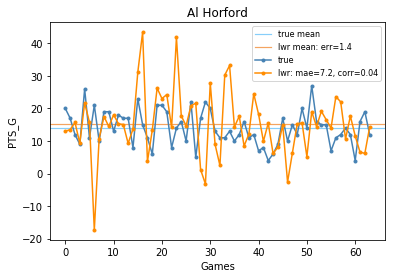

{'std': {'window': 3}, 'mean': {'window': 3}, 'ewm': {'window': 3, 'com': 0.7}, 'gmOutcome': {'window': 3, 'com': 0.3}, 'delta': {'window': 3, 'com': 0.7}, 'teammates': {'window': 3, 'n': 1, 'com': 0.7}, 'oppt': {'window': -1}, 'teamLoc': {}}
{'rank': 2, 'project': True, 'updateType': 'raw', 'updatePeriod': 10}
{'type': 'lwr', 'params': {'kernel': 'rbf', 'fit_intercept': True}}


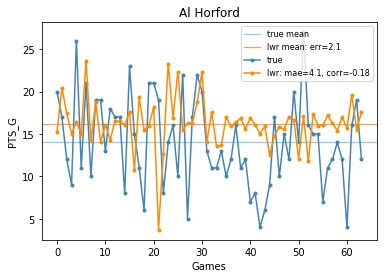

{'std': {'window': 3}, 'mean': {'window': 3}, 'ewm': {'window': 3, 'com': 0.7}, 'gmOutcome': {'window': 3, 'com': 0.3}, 'delta': {'window': 3, 'com': 0.7}, 'teammates': {'window': 3, 'n': 1, 'com': 0.7}, 'oppt': {'window': -1}, 'teamLoc': {}}
{'rank': 0, 'project': True, 'updateType': 'raw', 'updatePeriod': 10}
{'type': 'lwr', 'params': {'kernel': 'sigmoid', 'fit_intercept': True}}


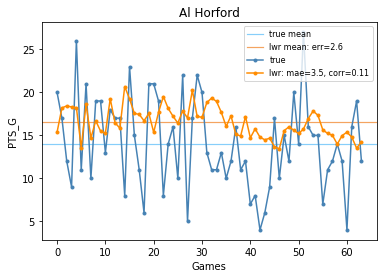

{'std': {'window': 3}, 'mean': {'window': 3}, 'ewm': {'window': 3, 'com': 0.7}, 'gmOutcome': {'window': 3, 'com': 0.3}, 'delta': {'window': 3, 'com': 0.7}, 'teammates': {'window': 3, 'n': 1, 'com': 0.7}, 'oppt': {'window': -1}, 'teamLoc': {}}
{'rank': 2, 'project': True, 'updateType': 'raw', 'updatePeriod': 10}
{'type': 'lwr', 'params': {'kernel': 'sigmoid', 'fit_intercept': True}}


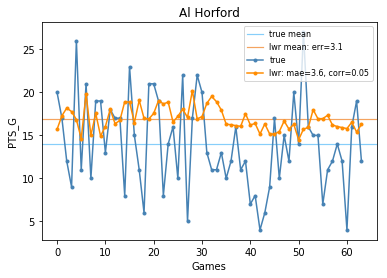

{'std': {'window': 3}, 'mean': {'window': 3}, 'ewm': {'window': 3, 'com': 0.7}, 'gmOutcome': {'window': 3, 'com': 0.3}, 'delta': {'window': 3, 'com': 0.7}, 'teammates': {'window': 3, 'n': 1, 'com': 0.7}, 'oppt': {'window': -1}, 'teamLoc': {}}
{'rank': 0, 'project': True, 'updateType': 'raw', 'updatePeriod': 10}
{'type': 'lwr', 'params': {'kernel': 'cosine', 'fit_intercept': True}}


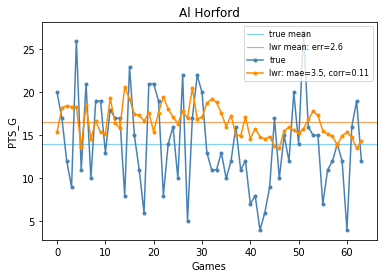

{'std': {'window': 3}, 'mean': {'window': 3}, 'ewm': {'window': 3, 'com': 0.7}, 'gmOutcome': {'window': 3, 'com': 0.3}, 'delta': {'window': 3, 'com': 0.7}, 'teammates': {'window': 3, 'n': 1, 'com': 0.7}, 'oppt': {'window': -1}, 'teamLoc': {}}
{'rank': 2, 'project': True, 'updateType': 'raw', 'updatePeriod': 10}
{'type': 'lwr', 'params': {'kernel': 'cosine', 'fit_intercept': True}}


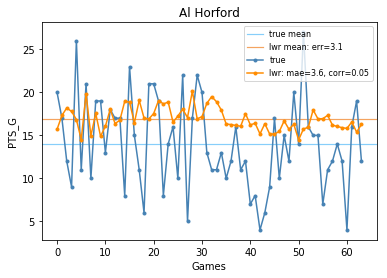

{'std': {'window': 3}, 'mean': {'window': 3}, 'ewm': {'window': 3, 'com': 0.7}, 'gmOutcome': {'window': 3, 'com': 0.3}, 'delta': {'window': 3, 'com': 0.7}, 'teammates': {'window': 3, 'n': 1, 'com': 0.7}, 'oppt': {'window': -1}, 'teamLoc': {}}
{'rank': 0, 'project': True, 'updateType': 'raw', 'updatePeriod': 10}
{'type': 'lwr', 'params': {'kernel': 'laplacian', 'fit_intercept': True}}


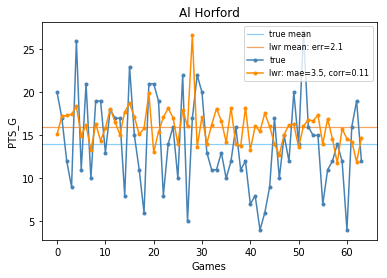

{'std': {'window': 3}, 'mean': {'window': 3}, 'ewm': {'window': 3, 'com': 0.7}, 'gmOutcome': {'window': 3, 'com': 0.3}, 'delta': {'window': 3, 'com': 0.7}, 'teammates': {'window': 3, 'n': 1, 'com': 0.7}, 'oppt': {'window': -1}, 'teamLoc': {}}
{'rank': 2, 'project': True, 'updateType': 'raw', 'updatePeriod': 10}
{'type': 'lwr', 'params': {'kernel': 'laplacian', 'fit_intercept': True}}


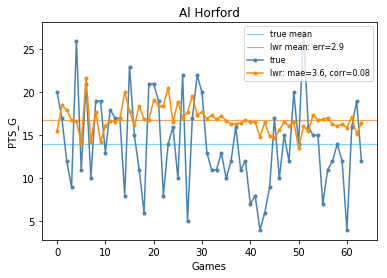

{'std': {'window': 3}, 'mean': {'window': 3}, 'ewm': {'window': 3, 'com': 0.7}, 'gmOutcome': {'window': 3, 'com': 0.3}, 'delta': {'window': 3, 'com': 0.7}, 'teammates': {'window': 3, 'n': 1, 'com': 0.7}, 'oppt': {'window': -1}, 'teamLoc': {}}
{'rank': 0, 'project': True, 'updateType': 'raw', 'updatePeriod': 10}
{'type': 'lwr', 'params': {'kernel': 'poly', 'fit_intercept': True}}


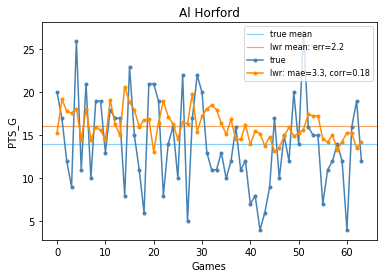

{'std': {'window': 3}, 'mean': {'window': 3}, 'ewm': {'window': 3, 'com': 0.7}, 'gmOutcome': {'window': 3, 'com': 0.3}, 'delta': {'window': 3, 'com': 0.7}, 'teammates': {'window': 3, 'n': 1, 'com': 0.7}, 'oppt': {'window': -1}, 'teamLoc': {}}
{'rank': 2, 'project': True, 'updateType': 'raw', 'updatePeriod': 10}
{'type': 'lwr', 'params': {'kernel': 'poly', 'fit_intercept': True}}


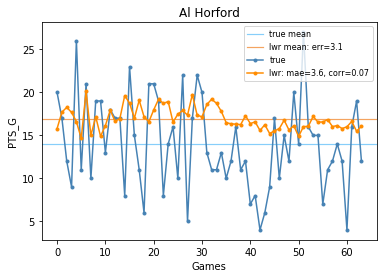

Al Horford: {'algo': 'auto', 'alpha': 1.0, 'fit_intercept': True, 'gmCom': 0.3, 'gmWindow': 3, 'kernel': 'poly', 'leaf_size': 30, 'n': 1, 'n_neighbors': 3, 'opptWindow': -1, 'project': True, 'radius': 4, 'rank': 0, 'statsCom': 0.7, 'statsWindow': 3, 'teamCom': 0.7, 'teamWindow': 3, 'type': 'lwr', 'updatePeriod': 10, 'updateType': 'raw', 'weights': 'distance'}
Error = 3.31
Al Horford: {'algo': 'auto', 'alpha': 1.0, 'fit_intercept': True, 'gmCom': 0.3, 'gmWindow': 3, 'kernel': 'poly', 'leaf_size': 30, 'n': 1, 'n_neighbors': 3, 'opptWindow': -1, 'project': True, 'radius': 4, 'rank': 0, 'statsCom': 0.7, 'statsWindow': 3, 'teamCom': 0.7, 'teamWindow': 3, 'type': 'lwr', 'updatePeriod': 10, 'updateType': 'raw', 'weights': 'distance'}
Corr = 0.18

{'std': {'window': 3}, 'mean': {'window': 3}, 'ewm': {'window': 3, 'com': 0.7}, 'gmOutcome': {'window': 3, 'com': 0.3}, 'delta': {'window': 3, 'com': 0.7}, 'teammates': {'window': 3, 'n': 1, 'com': 0.7}, 'oppt': {'window': -1}, 'teamLoc': {}}
{'rank'

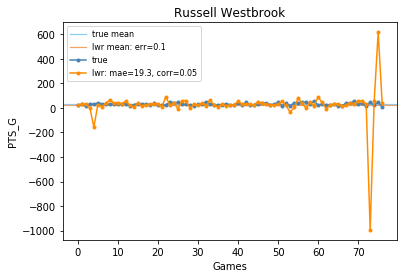

{'std': {'window': 3}, 'mean': {'window': 3}, 'ewm': {'window': 3, 'com': 0.7}, 'gmOutcome': {'window': 3, 'com': 0.3}, 'delta': {'window': 3, 'com': 0.7}, 'teammates': {'window': 3, 'n': 1, 'com': 0.7}, 'oppt': {'window': -1}, 'teamLoc': {}}
{'rank': 2, 'project': True, 'updateType': 'raw', 'updatePeriod': 10}
{'type': 'lwr', 'params': {'kernel': 'rbf', 'fit_intercept': True}}


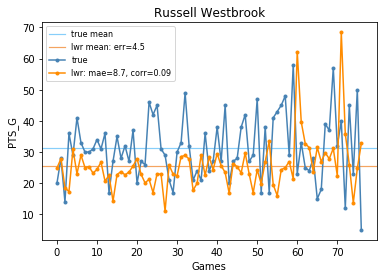

{'std': {'window': 3}, 'mean': {'window': 3}, 'ewm': {'window': 3, 'com': 0.7}, 'gmOutcome': {'window': 3, 'com': 0.3}, 'delta': {'window': 3, 'com': 0.7}, 'teammates': {'window': 3, 'n': 1, 'com': 0.7}, 'oppt': {'window': -1}, 'teamLoc': {}}
{'rank': 0, 'project': True, 'updateType': 'raw', 'updatePeriod': 10}
{'type': 'lwr', 'params': {'kernel': 'sigmoid', 'fit_intercept': True}}


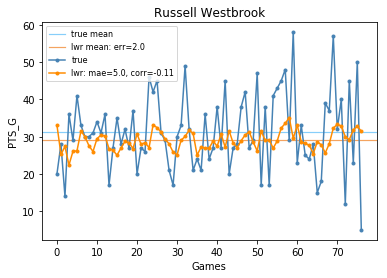

{'std': {'window': 3}, 'mean': {'window': 3}, 'ewm': {'window': 3, 'com': 0.7}, 'gmOutcome': {'window': 3, 'com': 0.3}, 'delta': {'window': 3, 'com': 0.7}, 'teammates': {'window': 3, 'n': 1, 'com': 0.7}, 'oppt': {'window': -1}, 'teamLoc': {}}
{'rank': 2, 'project': True, 'updateType': 'raw', 'updatePeriod': 10}
{'type': 'lwr', 'params': {'kernel': 'sigmoid', 'fit_intercept': True}}


KeyboardInterrupt: 

In [34]:
players = ['Al Horford', 'Russell Westbrook']
metric = 'PTS_G'

folderName = 'SLA/'
saveFig = False
errorType = 'mae'
players_optParamDict_error = {player: {} for player in players}
players_optParamDict_corr = {player: {} for player in players}
alpha = 1

for player in players:
    # create info and SLA dictionaries
    infoDict = {'player': player, 'metric': metric} 
    
    # initialize optimality conditions
    optParamDict_error = paramGrid[0]
    optParamDict_corr = paramGrid[0]
    error = float('inf')
    corr = -float('inf')
    
    # iterate through parameters
    for paramDict in paramGrid:
        # create parameter dictionaries
        infoDict, featuresDict, labelsDict, modelDict, slaDict = gamePredictions.getParamDicts(paramDict, infoDict, 
                                                                               featureTypes, labelType)
        #if 'delta' in list(featuresDict.keys()): 
            #infoDict['buffer'] += 1
            
        print(featuresDict)
        print(modelDict)
        print(slaDict)
        
        # train 
        dataDict = {'df': dfTrain, 'teamsDict': teamsTrainDict}
        SLA.trainSLA(infoDict, dataDict, featuresDict, labelsDict, modelDict, slaDict)
        
        # test 
        dataDict = {'df': dfCV, 'teamsDict': teamsCVDict}
        preds, true = SLA.testSLA(infoDict, dataDict, featuresDict, labelsDict, modelDict, slaDict)
        
        # restrict to games that we care about
        true_alpha, preds_alpha = gamePredictions.get_alpha_scores(true, preds, alpha)
        
        # compute correlation for restricted games
        corrTemp = gamePredictions.corr(preds_alpha, true_alpha)
        if corrTemp > corr: 
            corr = corrTemp
            optParamDict_corr = paramDict
            
        # compute error for restricted games
        errorTemp = gamePredictions.error(preds_alpha, true_alpha, errorType=errorType)
        if errorTemp < error: 
            error = errorTemp
            optParamDict_error = paramDict
            
        # plot
        seriesDict = {'type': slaDict['type'], 'data': preds}
        trueDict = {'data': true}
        plotData.plotGame(seriesDict, trueDict, player, alpha, errorType, folderName, metric, saveFig)
        
    # update player optimal hyperparameters
    players_optParamDict_error[player] = optParamDict_error
    players_optParamDict_corr[player] = optParamDict_corr
    
    # display results
    print("{}: {}".format(player, optParamDict_error))
    print("Error = {}".format(error.round(2)))
    print("{}: {}".format(player, optParamDict_corr))
    print("Corr = {}".format(corr.round(2)))
    print()
        

## Test

### Best by Error

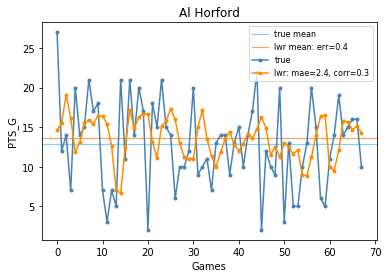

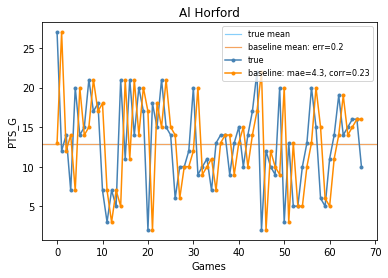

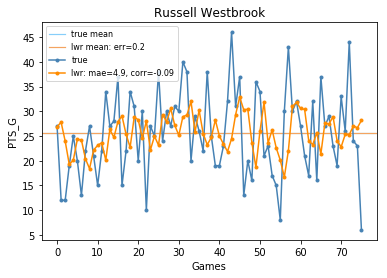

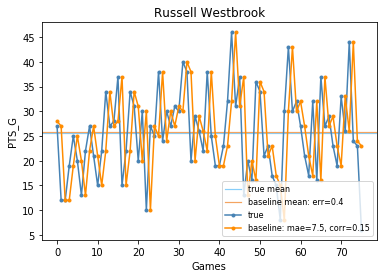

In [29]:
folderName = 'SLA/'
saveFig = False

slaErrorsDictWeek = {player: 0 for player in players}
slaErrorsDictMonth = {player: 0 for player in players}

for player in players:
    # create info and SLA dictionaries
    infoDict = {'player': player, 'metric': metric} 
    
    # get optimal hyperparameters for player
    optParamDict = players_optParamDict_error[player]

    # create parameter dictionaries
    infoDict, featuresDict, labelsDict, modelDict, slaDict = gamePredictions.getParamDicts(optParamDict, infoDict, 
                                                                           featureTypes, labelType)     
    #if 'delta' in list(featuresDict.keys()): 
     #       infoDict['buffer'] += 1
            
    # train 
    dataDict = {'df': dfTrainCV, 'teamsDict': teamsTrainCVDict}
    SLA.trainSLA(infoDict, dataDict, featuresDict, labelsDict, modelDict, slaDict)
        
    # test 
    dataDict = {'df': dfTest, 'teamsDict': teamsTestDict}
    preds, true = SLA.testSLA(infoDict, dataDict, featuresDict, labelsDict, modelDict, slaDict)
               
    # plot
    seriesDict = {'type': slaDict['type'], 'data': preds}
    trueDict = {'data': true}
    plotData.plotGame(seriesDict, trueDict, player, alpha, errorType, folderName, metric, saveFig)
    
    # compare against baseline
    predsBase, _ = gamePredictions.baselineForecast(dfTest, player, window=1, buffer=infoDict['buffer'])
    seriesDict = {'type': 'baseline', 'data': predsBase}
    plotData.plotGame(seriesDict, trueDict, player, alpha, errorType, folderName, metric, saveFig)


### Best by Correlation

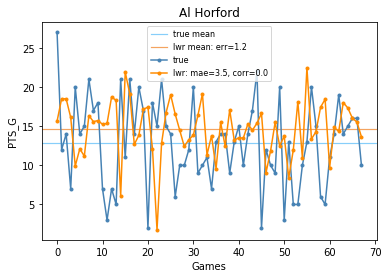

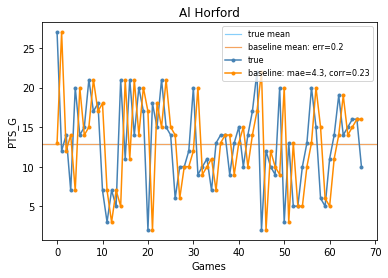

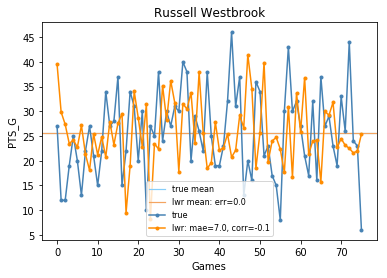

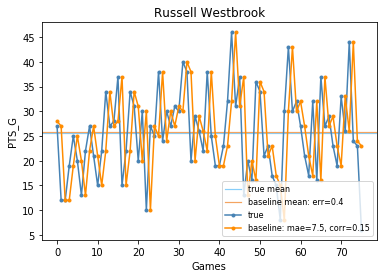

In [30]:
folderName = 'SLA/'
saveFig = False

slaErrorsDictWeek = {player: 0 for player in players}
slaErrorsDictMonth = {player: 0 for player in players}

for player in players:
    # create info and SLA dictionaries
    infoDict = {'player': player, 'metric': metric} 
    
    # get optimal hyperparameters for player
    optParamDict = players_optParamDict_corr[player]
    
    # create parameter dictionaries
    infoDict, featuresDict, labelsDict, modelDict, slaDict = gamePredictions.getParamDicts(optParamDict, infoDict, 
                                                                           featureTypes, labelType)     
    #if 'delta' in list(featuresDict.keys()): 
     #       infoDict['buffer'] += 1
            
    # train 
    dataDict = {'df': dfTrainCV, 'teamsDict': teamsTrainCVDict}
    SLA.trainSLA(infoDict, dataDict, featuresDict, labelsDict, modelDict, slaDict)
        
    # test 
    dataDict = {'df': dfTest, 'teamsDict': teamsTestDict}
    preds, true = SLA.testSLA(infoDict, dataDict, featuresDict, labelsDict, modelDict, slaDict)
               
    # plot
    seriesDict = {'type': slaDict['type'], 'data': preds}
    trueDict = {'data': true}
    plotData.plotGame(seriesDict, trueDict, player, alpha, errorType, folderName, metric, saveFig)
    
    # compare against baseline
    predsBase, _ = gamePredictions.baselineForecast(dfTest, player, window=1, buffer=infoDict['buffer'])
    seriesDict = {'type': 'baseline', 'data': predsBase}
    plotData.plotGame(seriesDict, trueDict, player, alpha, errorType, folderName, metric, saveFig)


In [ ]:

    """optParamDict = {'algo': 'auto', 'alpha': 1.0, 'gmCom': 0.5, 'gmWindow': 3, 
                    'leaf_size': 30, 'n': 1, 'n_neighbors': 3, 'opptWindow': -1, 
                    'project': True, 'radius': 4, 'rank': 4, 'statsCom': 0.8, 'statsWindow': 3, 
                    'teamCom': 0.8, 'teamWindow': 3, 'type': 'knn', 'weights': 'distance'}"""
    
    """optParamDict = {'algo': 'auto', 'alpha': 1.0, 'gmCom': 0.3, 'gmWindow': 3, 'leaf_size': 30, 
                    'n': 1, 'n_neighbors': 3, 'opptWindow': -1, 'project': True, 'radius': 4, 
                    'rank': 2, 'statsCom': 0.7, 'statsWindow': 3, 'teamCom': 0.7, 'teamWindow': 3, 
                    'type': 'knn', 'update': True, 'updatePeriod': 1, 'weights': 'distance'}"""

## ARIMA Predictions

In [ ]:
""" Set ARIMA Hyper-parameters """
#d = np.linspace(3, 10, 3)
d = np.array([3])
p = np.array([1])
q = np.array([0])

""" Create ARIMA Parameter Grids """
arimaDict = {'d': d, 'p': p, 'q': q}
arimaGrid = list(ParameterGrid(arimaDict))

# players
playerARIMA_paramsDict = {player: dict() for player in players}

# folder name
folderName = 'ARIMA/'

In [ ]:
""" TRAIN + CV Stages """
saveFig = False 

for player in players: 
    buffer = playerSLA_paramsDict[player]['windowSize']
    
    # initialize optimality conditions
    optARIMA_params = arimaGrid[0]
    error = float("inf")
    
    for paramDict in arimaGrid:
        print("{}".format(paramDict))
        
        # train and forecast on cv
        predsARIMA, true = gamePredictions.ARIMATrainTest(paramDict, dfTrain, dfCV, player, buffer, metric)
        
        # compute error
        errorTemp = rmseMA(predsARIMA, true, weekWindow)
        if errorTemp <= error: 
            error = errorTemp
            optARIMA_params = paramDict
        
        # plot
        plotData.plotMA(predsARIMA, true, weekWindow, player, folderName, metric, saveFig)
        plotData.plotMA(predsARIMA, true, monthWindow, player, folderName, metric, saveFig)
    
    # update player params
    playerARIMA_paramsDict[player] = optARIMA_params
    
    print("{}: optimal ARIMA params = {}".format(player, optARIMA_params))
    print("Error = {}".format(error.round(2)))
    print()
    

In [ ]:
""" TEST """
arimaErrorsDictWeek = {player: 0 for player in players}
arimaErrorsDictMonth = {player: 0 for player in players}
saveFig = True

for player in players:
    # get optimal hyperparameters
    optARIMA_params = playerARIMA_paramsDict[player]
    buffer = playerSLA_paramsDict[player]['windowSize']
    
    # train on (train, cv) data and forecast on test
    predsARIMA, true = gamePredictions.ARIMATrainTest(optARIMA_params, dfTrainCV, dfTest, player, buffer, metric)
    
    # compute error (minimize w.r.t. weekly error)
    error = rmseMA(predsARIMA, true, weekWindow)
    arimaErrorsDictWeek[player] = round(error, roundNum)
    error = rmseMA(predsARIMA, true, monthWindow)
    arimaErrorsDictMonth[player] = round(error, roundNum)

    # plot
    plotData.plotMA(predsARIMA, true, weekWindow, player, folderName, metric, saveFig)
    plotData.plotMA(predsARIMA, true, monthWindow, player, folderName, metric, saveFig)

# Annual Predictions

In [3]:
predMetrics = ["PTS_G"]

players = ['Russell Westbrook', 'James Harden',
       'DeMar DeRozan', 'Stephen Curry', 'LeBron James',
       'Kawhi Leonard',
        'Kemba Walker',
       'Kyrie Irving', 'Jimmy Butler', 'John Wall', 'Dwyane Wade',
       'Paul George', 'Klay Thompson', 'Carmelo Anthony',
       'Gordon Hayward', 'Kevin Durant', 'Brook Lopez',
       'Goran Dragic', 'Marc Gasol', 'Lou Williams', 'Chris Paul',
          'Al Horford', 'Al Jefferson','LaMarcus Aldridge', 'Manu Ginobili', 'Tony Parker',
          'Dwight Howard', 'Trevor Ariza', 'Zach Randolph', 'Vince Carter', 'Rudy Gay', 'Kevin Love',
          'Dirk Nowitzki', 'DeAndre Jordan', 'Blake Griffin', 'Andre Iguodala', 'Arron Afflalo',
          'Avery Bradley', 'Beno Udrih', 'C.J. Miles', 'Corey Brewer', 'David Lee', 'David West',
          'Deron Williams', 'Derrick Rose', 'Greg Monroe', 'J.J. Barea',
 'J.J. Redick', 'J.R. Smith', 'Jamal Crawford', 'Jameer Nelson', 'Jason Terry', 'Jeff Green', 'Jared Dudley', 'Joe Johnson', 
          'Jose Calderon', 'Kenneth Faried', 'Kyle Korver', 'Kyle Lowry', 'Leandro Barbosa', 'Marcin Gortat',
 'Marco Belinelli', 
 'Marcus Thornton',
 'Marreese Speights',
 'Marvin Williams',
 'Matt Barnes', 'Mike Conley', 'Michael Beasley','Monta Ellis',
 'Nene Hilario',
 'Nick Young',
 'Nicolas Batum','Omer Asik',
 'Omri Casspi',
           'Pau Gasol',
           'Paul Millsap',
 'Rajon Rondo',
 'Ramon Sessions',
 'Randy Foye',
 'Raymond Felton',
 'Reggie Jackson',
 'Richard Jefferson',
 'Robin Lopez',
 'Rodney Stuckey',
 'Roy Hibbert',
          'Serge Ibaka',
 'Shaun Livingston',
 'Spencer Hawes','Taj Gibson', 'Tony Allen', 'Wayne Ellington',
 'Wesley Johnson',
 'Wesley Matthews', 'Zaza Pachulia']

## Adding 2018 Data

In [8]:
d1 = '2017-09-01'
d2 = '2018-06-01'
df = pd.read_csv("../data/nba-enhanced-stats/2012-18_playerBoxScore.csv")
df_recent = df[(df.gmDate >= d1) & (df.gmDate <= d2)]

colname_dict = {'playPTS': 'PTS', 'playAST': 'AST', 'playTO':'TOV',
                'playFG%': 'FG%','playFT%':'FT%','play3PM':'3P',
                'playTRB':'TRB','playSTL':'STL','playBLK':'BLK',
                'teamAbbr': 'Tm', 'playPos': 'Pos', 'playMin': 'MP',
                'playDispNm': 'Player'}
df_recent = df_recent.rename(columns=colname_dict)

# add games played
numGmsPlayed = df_recent.groupby(['Player']).count()['gmDate'].values

# take totals 
sumColumns = ['PTS', 'AST', 'TOV', '3P', 'TRB', 'STL', 'BLK', 'MP']
avgColumns = ['FG%', 'FT%']
d = {sumColumn: 'sum' for sumColumn in sumColumns}
dtemp = {avgColumn: 'mean' for avgColumn in avgColumns}
d.update(dtemp)
df_recent = df_recent.groupby(['Player'], as_index=False).agg(d)
df_recent['Year'] = 2018

# fix accented characters
df_recent.Player = df_recent.Player.str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')

# add games played
df_recent['G'] = numGmsPlayed

## RSC Predictions

In [9]:
""" USER PARAMETERS """
starting_year = 1970
min_games = 30
min_years = 2
validate_year = 2017
pred_interval = 1
params = [starting_year, min_games, min_years, validate_year, pred_interval]

In [10]:
"""
setup
"""
# user input
donor_window_type = 'sliding'
normalize_metric = None 
threshold = 0.98
helper_metrics = []

# setup 
donorSetup= [normalize_metric, donor_window_type, True]
denoiseSetup = ["SVD", "all"]
regression_method = "pinv"
verbose = False
metrics = [[metric] + helper_metrics for metric in predMetrics]

In [11]:
# create annual data
stats = annualData.createAnnualData(params, df_recent)

AttributeError: module 'mrsc.src.dataPrep.annualData' has no attribute 'createAnnualData'

In [ ]:
# create donor / target for validation
donor_v, allPivotedTableDict_v, _, _ = annualData.createTargetDonors(params, stats)

# create donor / target for testing (update prediction year)
params[3] = params[3] + 1
donor, allPivotedTableDict, targetPlayers, stats = annualData.createTargetDonors(params, stats)

In [ ]:
validPlayers = list(set(players) & set(targetPlayers))
validPlayers.sort()

In [ ]:
# create evaluation dataframes
all_pred = pd.DataFrame()
all_true = pd.DataFrame()
all_val = pd.DataFrame()

method = 'Convex'
alpha = 0.1
arima_params = (1,1,0)
ewm_param = 0.3

# use 'targetPlayers' from 'pred_year'
for targetPlayer in validPlayers: 
    player_pred = pd.DataFrame()
    player_true = pd.DataFrame()
    player_val = pd.DataFrame()
    
    for metric in metrics: 
        """ VALIDATION STAGE """
        # get predictions
        preds_val, y_val = annualPredictions.getPredictions(targetPlayer, allPivotedTableDict_v, donor_v, 
                                                            pred_interval, metric, predMetrics, threshold, 
                                                            donorSetup, denoiseSetup, regression_method, 
                                                            verbose, arima_params, ewm_param)
        
        # learn weights
        weights = predictionMethods.learnWeights(preds_val, y_val, method, alpha)
        
        """ PREDICTION STAGE """
        # get predictions
        preds_test, y_test = annualPredictions.getPredictions(targetPlayer, allPivotedTableDict, donor, 
                                                              pred_interval, metric, predMetrics, threshold, 
                                                              donorSetup, denoiseSetup, regression_method, 
                                                              verbose, arima_params, ewm_param)
        
        # make final predictions
        pred_final = predictionMethods.combinePredictions(preds_test, weights) 
        
        """ PRESENTATION STAGE """   
        df_pred = pd.DataFrame(pred_final)
        df_pred.columns = [targetPlayer]
        df_pred.index = [metric]
        player_pred = pd.concat([player_pred, df_pred], axis=0)
        
        df_true = pd.DataFrame(y_test)
        df_true.columns = [targetPlayer]
        df_true.index = [metric]
        player_true = pd.concat([player_true, df_true], axis=0)
        
    all_pred = pd.concat([all_pred, player_pred], axis=1)
    all_true = pd.concat([all_true, player_true], axis=1)
    
print("DONE!")

In [ ]:
error = all_true - all_pred
all_true.index = ['True']
all_pred.index = ['Pred']
error.index = ['Error']
df_annual = pd.concat([all_true, all_pred, error]).T
#df_annual.sort_values(by=['Error']).head()

In [ ]:
df_annual.head()

In [ ]:
""" create dictionary of top n players per team """
n = 2

df = df_games[(df_games.gmDate >= cvDates[0]) & (df_games.gmDate <= cvDates[1])]

teams = df.teamAbbr.unique()
teamsDict = {team: [] for team in teams}
for team in teams: 
    dfTeam = df[df.teamAbbr == team]
    dfAvg = dfTeam.groupby('Player', as_index=False)['PTS_G'].mean()
    teamsDict[team] = dfAvg.nlargest(n, columns=['PTS_G'])['Player'].values

In [ ]:
""" CORRELATION BETWEEN PERFORMANCES OF TOP TWO PLAYERS PER TEAM """
n = 2
teams = df.teamAbbr.unique()
teamsDict = {team: [] for team in teams}
for team in teams:
    # get team dataframe
    dfTeam = df[df.teamAbbr == team]
    
    # get top n players per team
    dfAvg = dfTeam.groupby('Player', as_index=False)['PTS_G'].mean()
    topPlayers = dfAvg.nlargest(n, columns=['PTS_G'])['Player'].values
    teamsDict[team] = topPlayers
    
    # get dates in which all players played
    dfTeamTop = dfTeam.loc[dfTeam.Player.isin(topPlayers), ['gmDate', 'Player', 'PTS_G']]
    dates = dfTeamTop.gmDate.unique()
    validDates = list()
    for date in dates:
        if dfTeamTop[dfTeamTop.gmDate == date].count()['gmDate'] == n: 
            validDates.append(date)
    dfTeamTop = dfTeamTop[dfTeamTop.gmDate.isin(validDates)]
    
    plt.figure()
    for player in topPlayers:
        vals = dfTeamTop.loc[dfTeamTop.Player==player, 'PTS_G'].values
        plt.plot(vals, label=player)
    plt.legend(loc='best')
    plt.title(team)
    plt.show()
    
    series1 = pd.Series(dfTeamTop.loc[dfTeamTop.Player==topPlayers[0], 'PTS_G'].values)
    print("Correlation = {}".format(series1.corr(pd.Series(vals))))

In [ ]:
""" TEAM PTS/G WITH AND WITHOUT TOP PLAYERS """

cols = ['gmDate', 'Player', 'playStat', 'teamAbbr', 'teamLoc', 'teamRslt', 'opptAbbr', 'PTS_G']
df = df_games.loc[(df_games.gmDate >= testDates[0]) & (df_games.gmDate <= testDates[1]), cols]

team = 'HOU'
players = teamsDict[team]
p1 = players[0]
p2 = players[1]

dfTeam = df[df.teamAbbr == team]
dfTop = dfTeam[dfTeam.Player.isin([p1, p2])]

dates = dfTop.gmDate.unique()
overlapDates = list()
nonOverlapDates = list()
for date in dates:
    if dfTop[dfTop.gmDate == date].count()['gmDate'] == 2: 
        overlapDates.append(date)
    else:
        nonOverlapDates.append(date)
        
""" Get Team PTS_G up to (but no including) date """
def getTeamPTS_G(dfTeam, date): 
    df = dfTeam.loc[dfTeam.gmDate < date]
    return df['PTS_G'].sum() / len(df.gmDate.unique())

""" Get Team PTS on date """
def getTeamPTS(dfTeam, date): 
    df = dfTeam.loc[dfTeam.gmDate == date]
    return df['PTS_G'].sum() 

for date in nonOverlapDates: 
    pts = getTeamPTS(dfTeam, date)
    pts_g = getTeamPTS_G(dfTeam, date)

    print("Date: {}".format(date))
    print("Scored {} points".format(pts, date))
    print("AVG {} points".format(pts_g, date))
    print()

In [ ]:
""" PTS/G WITH AND WITHOUT TEAMMATE """

for team, players in teamsDict.items(): 
    p1 = players[0]
    p2 = players[1]

    dfTeam = df[df.teamAbbr == team]
    dfTop = dfTeam[dfTeam.Player.isin([p1, p2])]

    dates = dfTop.gmDate.unique()
    overlapDates = list()
    nonOverlapDates = list()
    for date in dates:
        if dfTop[dfTop.gmDate == date].count()['gmDate'] == 2: 
            overlapDates.append(date)
        else:
            nonOverlapDates.append(date)

    p1Avg = dfTop.loc[(dfTop.Player==p1) & (dfTop.gmDate.isin(overlapDates)), 'PTS_G'].mean()
    df1 = dfTop.loc[(dfTop.Player==p1) & (dfTop.gmDate.isin(nonOverlapDates)), ['gmDate', 'Player', 'PTS_G']]
    df1['Overlap AVG'] = p1Avg

    p2Avg = dfTop.loc[(dfTop.Player==p2) & (dfTop.gmDate.isin(overlapDates)), 'PTS_G'].mean()
    df2 = dfTop.loc[(dfTop.Player==p2) & (dfTop.gmDate.isin(nonOverlapDates)), ['gmDate', 'Player', 'PTS_G']]
    df2['Overlap AVG'] = p2Avg
    
    print("*** {} ***".format(team))
    #print(df1)
    diff1 = df1['PTS_G'].mean() - p1Avg
    print("{} Diff = {}".format(p1, round(diff1, 2)))
    #print(df2)
    
    diff2 = df2['PTS_G'].mean() - p2Avg
    print("{} Diff = {}".format(p2, round(diff2, 2)))
    print()

In [ ]:
""" Set SLA Parameters """
# SLA Params
slaType = 'linear'
numFeatureTypes = ['std', 'mean', 'ewm']
catFeatureTypes = ['teamLoc', 'gameOutcome']
labelType = None 

""" Set SLA Hyper-parameters """
windowSizes = np.array([1, 3, 5])
rank = np.array([1, 2, 3])
ewm = np.linspace(0.1, 1.0, 5)
n = np.array([2])

# SVR
C = np.linspace(0.1, 1, 5)
gamma = ['auto', 'scale']
degree = np.array([2, 3])
epsilon = np.linspace(0.1, 0.3, 3)

# Ridge
alpha = np.linspace(0.1, 1, 5)

# RandomForest
n_estimators = np.array([8, 16, 32])
max_depth = np.array([1, 8, 16, 32])
min_samples_split = np.array([0.1, 0.3])
min_samples_leaf = np.array([0.1, 0.3])

""" Create SLA Parameter Grids """
hyperParamDict = {'windowSize': windowSizes, 'rank': rank, 'ewm': ewm, 'n': n}
svrDict = {'C': C, 'gamma': gamma, 'degree': degree, 'epsilon': epsilon}
ridgeDict = {'alpha': alpha}
randomForestDict = {'n_estimators': n_estimators, 'max_depth': max_depth, 
                    'min_samples_split': min_samples_split, 
                    'min_samples_leaf': min_samples_leaf}

svrDict.update(hyperParamDict)
ridgeDict.update(hyperParamDict)
randomForestDict.update(hyperParamDict)

lrGrid = list(ParameterGrid(hyperParamDict))
svrGrid = list(ParameterGrid(svrDict))
ridgeGrid = list(ParameterGrid(ridgeDict))
randomForestGrid = list(ParameterGrid(randomForestDict))

""" Create dictionary of optimal parameters per player """
playerSLA_paramsDict = {player: dict() for player in players} 